## DSAI5102 — Tutorial 2
  
**Topic**: Random + NumPy + Pandas Basics & Titanic Mini Project

	•	Understand reproducibility and seeding across libraries.
	•	Use Python random and NumPy RNGs correctly.
	•	Perform core matrix operations with NumPy.
	•	Manipulate tabular data with Pandas (load, clean, sample, save).
	•	Simulate and visualize discrete/continuous probability distributions.
	•	Persist data and results (CSV/NumPy files).


### Part 1 Random Number & Reproducibility Setup

	•	We’ll use both Python’s built-in random and NumPy’s RNGs.
	•	Reproducibility means others (or you later) get the same results with the same code + seed + environment.

Checklist for reproducible runs

	•	Fix seeds (random, NumPy, and your ML framework, e.g., PyTorch).
	•	Record package versions (e.g., np.__version__, pd.__version__).
	•	Save your data splits and outputs (CSV/NPZ).
	•	Avoid re-seeding inside loops.

In [12]:
import random, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42

In [13]:
# 1) Python’s built-in RNG
random.seed(SEED)

In [16]:
# 2) NumPy legacy global RNG (RandomState) — still common in codebases
np.random.seed(SEED)

print("Seed set to:", SEED)
print("Python:", sys.version.split()[0],
      "| NumPy:", np.__version__,
      "| Pandas:", pd.__version__)

Seed set to: 42
Python: 3.12.11 | NumPy: 2.0.2 | Pandas: 2.2.2


(Optional) Modern NumPy Generator API

NumPy recommends using an independent generator instead of the global singleton:

	•	rng = np.random.default_rng(SEED) creates an isolated stream (PCG64).
	•	Safer for libraries/modules to avoid interfering with each other.

We’ll keep using the legacy global API for simplicity in this tutorial, but here is the modern pattern:

In [24]:
SEED = 42
rng = np.random.default_rng(SEED)

state0 = rng.bit_generator.state      # Save the generator state before any sampling
s1 = rng.random(3)                    # First sampling & advance state
rng.bit_generator.state = state0      # Restore to the state before sampling
s1_again = rng.random(3)              # Should be identical to s1
print(s1, s1_again)

[0.77395605 0.43887844 0.85859792] [0.77395605 0.43887844 0.85859792]


Two common needs

	1.	Reproducibility: You want to ensure that every run generates the same random numbers (starting from the beginning).
	2.	Continuation: You want to resume from where you left off in the random sequence, not restart it.

Quick rule of thumb:

	•	If you just need consistent results → save the seed (simplest, recommended).
	•	If you need to continue the sequence → save the generator’s state to a file and restore it later.

In [25]:
# A. Saving only the seed (most common & simplest)
# Use case: ensures reproducibility of experiments.

SEED = 42  # record this in your README/Notebook
rng = np.random.default_rng(SEED)

# Every session with the same SEED will produce identical sequences
print(rng.random(5))

[0.77395605 0.43887844 0.85859792 0.69736803 0.09417735]


In [40]:
# B. Saving & restoring the generator state (for continuation)
# Using pickle (binary file)
# Quick to use, but avoid loading pickled data from untrusted sources (security risk).

# First session

import numpy as np, pickle

rng = np.random.default_rng(42)
state0 = rng.bit_generator.state         # save BEFORE sampling
s1 = rng.random(3)
with open("rng_state.pkl", "wb") as f:
    pickle.dump(state0, f)
print("s1:", s1)

s1: [0.77395605 0.43887844 0.85859792]


In [41]:
# ===== New session: restore & continue =====
import numpy as np, pickle

rng = np.random.default_rng(42)  # create a generator
with open("rng_state.pkl", "rb") as f:
    state = pickle.load(f)

rng.bit_generator.state = state             # restore to the saved point
print("resume sample:", rng.random(3))      # continues sequence

resume sample: [0.77395605 0.43887844 0.85859792]


---

### Part 2 — Introduction to NumPy

NumPy = Numerical Python.
It is not included in the base Python distribution, so we import it explicitly.

We usually abbreviate it as np for convenience.

In [42]:
#Code

import numpy as np

Arrays vs Python Lists

	•	A NumPy array is a multidimensional container of numbers.
	•	Arrays support elementwise arithmetic.
	•	Compare to Python lists: adding lists concatenates, while adding arrays performs elementwise addition.


In [45]:
x = np.array([3, 4, 5])
y = np.array([4, 9, 7])

print("x:", x)
print("y:", y)
print("x + y =", x + y)   # elementwise addition


# Compare with lists

print([3,4,5] + [4,9,7])  # concatenation

x: [3 4 5]
y: [4 9 7]
x + y = [ 7 13 12]
[3, 4, 5, 4, 9, 7]


Exercise 1

	1.	Create two arrays [1,2,3] and [4,5,6].
	2.	Compute their sum and product.
	3.	Compare the result to adding two Python lists.

In [ ]:
# type your code here! >😊<

Two-Dimensional Arrays (Matrices)

  NumPy arrays can be multi-dimensional.

	•	Vectors = 1D arrays
	•	Matrices = 2D arrays

In [48]:
X = np.array([[1, 2], [3, 4]])
print("Matrix X:\n", X)

print("Number of dimensions:", X.ndim)
print("Shape (rows, cols):", X.shape)
print("Data type:", X.dtype)

Matrix X:
 [[1 2]
 [3 4]]
Number of dimensions: 2
Shape (rows, cols): (2, 2)
Data type: int64


In [49]:
# Note: NumPy chooses the data type based on the input.
# 	  •	If you mix integers and floats, the result is a float array.
print(np.array([[1, 2], [3.0, 4]]).dtype)  # float64


float64


Attributes and Methods

	•	Attributes: ndim, dtype, shape, T (transpose)
	•	Methods: sum(), reshape(), etc.

In [53]:
# sum
x = np.array([1, 2, 3, 4])
print("Sum using method:", x.sum())
print("Sum using function:", np.sum(x))

# reshape
x2 = np.array([1, 2, 3, 4, 5, 6])
print("Original x2:", x2)
print("Reshaped (2x3):\n", x2.reshape((2, 3)))


Sum using method: 10
Sum using function: 10
Original x2: [1 2 3 4 5 6]
Reshaped (2x3):
 [[1 2 3]
 [4 5 6]]


Exercise 2

	1.	Create a 1D array of length 6.
	2.	Reshape it into a 3x2 matrix.
	3.	Compute its transpose.

In [ ]:
# type your code here! >😊<

Indexing and Slicing

NumPy uses 0-based indexing.

	•	A[i, j] → element at row i, column j
	•	Slices work like Python lists.


In [55]:
X = np.array([[1, 2, 3],
[4, 5, 6]])

print("X:\n", X)
print("Top-left element:", X[0, 0])
print("Element at (1,2):", X[1, 2])
print("First row:", X[0])
print("First column:", X[:, 0])

X:
 [[1 2 3]
 [4 5 6]]
Top-left element: 1
Element at (1,2): 6
First row: [1 2 3]
First column: [1 4]


Array Views and Memory Sharing

	•	Reshaping an array often shares memory with the original array.
	•	Modifying one will modify the other.

In [58]:
x = np.array([1, 2, 3, 4, 5, 6])
x_reshape = x.reshape((2, 3))

print("x before:", x)
x_reshape[0, 0] = 99
print("x_reshape after modification:\n", x_reshape)
print("x after modification:", x)

x before: [1 2 3 4 5 6]
x_reshape after modification:
 [[99  2  3]
 [ 4  5  6]]
x after modification: [99  2  3  4  5  6]


Exercise 3

	1.	Create a 1D array of 8 integers.
	2.	Reshape it into 2x4.
	3.	Modify one element in the reshaped version and observe the original array.

In [ ]:
# type your code here! >😊<

Mathematical Functions

NumPy applies math operations elementwise.

In [62]:
x = np.array([1, 2, 3, 4, 5, 6])

print("Square root:", np.sqrt(x))   # 元素开平方 -> 浮点结果
print("Squared:", x**2)             # 元素平方
print("x**0.5:", x**0.5)            # 与 sqrt 等价（当 x>=0）

Square root: [1.         1.41421356 1.73205081 2.         2.23606798 2.44948974]
Squared: [ 1  4  9 16 25 36]
x**0.5: [1.         1.41421356 1.73205081 2.         2.23606798 2.44948974]


---

### Part 3 — Matrix Computations with NumPy



Creating Matrices

In NumPy, a matrix is usually represented as a 2D ndarray.

In [63]:
import numpy as np

# Create 2x2 matrices
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

print("Matrix A:\n", A)
print("Matrix B:\n", B)

Matrix A:
 [[1 2]
 [3 4]]
Matrix B:
 [[5 6]
 [7 8]]


Basic Matrix Operations

	•	Addition / Subtraction: elementwise
	•	Scalar multiplication: multiply each element
	•	Elementwise multiplication: *
	•	Matrix multiplication: @ or np.dot()

In [64]:
print("A + B:\n", A + B)
print("A - B:\n", A - B)
print("2 * A:\n", 2 * A)

print("Elementwise product (Hadamard):\n", A * B)
print("Matrix product A @ B:\n", A @ B)   # or np.dot(A, B)

A + B:
 [[ 6  8]
 [10 12]]
A - B:
 [[-4 -4]
 [-4 -4]]
2 * A:
 [[2 4]
 [6 8]]
Elementwise product (Hadamard):
 [[ 5 12]
 [21 32]]
Matrix product A @ B:
 [[19 22]
 [43 50]]


Exercise 1

	1.	Create a 3×3 random integer matrix.
	2.	Compute its transpose.
	3.	Compute the matrix product with its transpose.


Transpose, Determinant, Inverse

NumPy provides functions in np.linalg for linear algebra.

In [65]:
# Transpose
print("A^T:\n", A.T)

# Determinant
print("det(A):", np.linalg.det(A))

# Inverse
A_inv = np.linalg.inv(A)
print("A^-1:\n", A_inv)

# Verify A @ A^-1 ≈ I
print("Check A @ A^-1:\n", A @ A_inv)

A^T:
 [[1 3]
 [2 4]]
det(A): -2.0000000000000004
A^-1:
 [[-2.   1. ]
 [ 1.5 -0.5]]
Check A @ A^-1:
 [[1.0000000e+00 0.0000000e+00]
 [8.8817842e-16 1.0000000e+00]]


Exercise 2

	1.	Generate a 2×2 matrix with random values.
	2.	Compute its determinant.
	3.	If invertible (det ≠ 0), calculate its inverse.

Solving Linear Systems

To solve *A x = b*, use np.linalg.solve.


In [66]:
b = np.array([1, 2])
x = np.linalg.solve(A, b)
print("Solution x:", x)

# Verify
print("A @ x:", A @ x)
print("b:", b)

Solution x: [0.  0.5]
A @ x: [1. 2.]
b: [1 2]


Eigenvalues and Eigenvectors

Used in PCA, graph analysis, etc.

In [67]:
w, v = np.linalg.eig(A)
print("Eigenvalues:", w)
print("Eigenvectors:\n", v)

Eigenvalues: [-0.37228132  5.37228132]
Eigenvectors:
 [[-0.82456484 -0.41597356]
 [ 0.56576746 -0.90937671]]


Singular Value Decomposition (SVD)

Important for dimensionality reduction, image compression, etc.

In [68]:
U, S, Vt = np.linalg.svd(A)
print("U:\n", U)
print("Singular values:", S)
print("V^T:\n", Vt)

U:
 [[-0.40455358 -0.9145143 ]
 [-0.9145143   0.40455358]]
Singular values: [5.4649857  0.36596619]
V^T:
 [[-0.57604844 -0.81741556]
 [ 0.81741556 -0.57604844]]


---

### Part 4 — Pandas Basics



Creating a DataFrame

Pandas provides two main objects:

	•	Series: a single column of data with an index.
	•	DataFrame: a table of rows and columns (like Excel).

In [69]:
import pandas as pd

# Create a DataFrame from a dictionary
data = {
    "Name": ["Alice", "Bob", "Cathy", "David"],
    "Score": [85, 92, 78, 90],
    "Age": [20, 21, 20, 22]
}

df = pd.DataFrame(data)
print("DataFrame:\n", df)

DataFrame:
     Name  Score  Age
0  Alice     85   20
1    Bob     92   21
2  Cathy     78   20
3  David     90   22


Exploring the Data

Some useful functions to quickly understand a dataset:

	•	df.head() → first rows
	•	df.info() → structure and datatypes
	•	df.describe() → summary statistics


In [70]:
print("First rows:\n", df.head())
print("\nInfo:")
print(df.info())
print("\nStatistics summary:\n", df.describe())

First rows:
     Name  Score  Age
0  Alice     85   20
1    Bob     92   21
2  Cathy     78   20
3  David     90   22

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    4 non-null      object
 1   Score   4 non-null      int64 
 2   Age     4 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 228.0+ bytes
None

Statistics summary:
            Score        Age
count   4.000000   4.000000
mean   86.250000  20.750000
std     6.238322   0.957427
min    78.000000  20.000000
25%    83.250000  20.000000
50%    87.500000  20.500000
75%    90.500000  21.250000
max    92.000000  22.000000


Selecting and Filtering

	•	Select a single column: df["Name"]
	•	Select multiple columns: df[["Name", "Age"]]
	•	Filter rows with a condition: df[df["Age"] > 20]

In [71]:
print("Name column:\n", df["Name"])
print("\nName and Age columns:\n", df[["Name", "Age"]])
print("\nFilter Age > 20:\n", df[df["Age"] > 20])

Name column:
 0    Alice
1      Bob
2    Cathy
3    David
Name: Name, dtype: object

Name and Age columns:
     Name  Age
0  Alice   20
1    Bob   21
2  Cathy   20
3  David   22

Filter Age > 20:
     Name  Score  Age
1    Bob     92   21
3  David     90   22


Grouping and Aggregation

Group rows by a key and apply an aggregate function.


In [72]:
print("Average score by Age:\n", df.groupby("Age")["Score"].mean())

Average score by Age:
 Age
20    81.5
21    92.0
22    90.0
Name: Score, dtype: float64


Missing Data

	•	df.isna() checks for missing values.
	•	df.fillna() fills missing values.
	•	df.dropna() removes rows with missing values.

In [73]:
# Introduce missing values
df.loc[1, "Score"] = None
print("With missing value:\n", df)

# Check missing
print("\nMissing values:\n", df.isna().sum())

# Fill missing values with mean
df_filled = df.fillna(df["Score"].mean())
print("\nAfter filling missing values:\n", df_filled)

With missing value:
     Name  Score  Age
0  Alice   85.0   20
1    Bob    NaN   21
2  Cathy   78.0   20
3  David   90.0   22

Missing values:
 Name     0
Score    1
Age      0
dtype: int64

After filling missing values:
     Name      Score  Age
0  Alice  85.000000   20
1    Bob  84.333333   21
2  Cathy  78.000000   20
3  David  90.000000   22


Exercise

	1.	Create a DataFrame with at least 2 missing values.
	2.	Fill numeric missing values with median.
	3.	Drop rows with missing categorical values.

Saving and Loading Data

Save DataFrame to CSV and reload it.

In [75]:
# Save
df_filled.to_csv("students.csv", index=False)

# Load
df_loaded = pd.read_csv("students.csv")
print("Reloaded DataFrame:\n", df_loaded)

Reloaded DataFrame:
     Name      Score  Age
0  Alice  85.000000   20
1    Bob  84.333333   21
2  Cathy  78.000000   20
3  David  90.000000   22


---

### Part 5 🚢 Mini Project — Titanic: Machine Learning from Disaster

Predict the binary target Survived (0/1) for passengers in test.csv using a baseline Logistic Regression pipeline. Emphasize reproducibility (fixed seed), NumPy/Pandas skills, and clear data handling.


In [2]:
# Reproducibility & imports
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

print("Seed set to", SEED)

Seed set to 42


Load the data

	•	Place train.csv and test.csv (from the Kaggle Titanic competition) in the current working directory.
	•	Inspect basic structure and missing values.

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/DSAI_5102/2_class_20250912Fri/data/train.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/DSAI_5102/2_class_20250912Fri/data/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print("\nTrain head:")
display(train_df.head())

print("\nMissing values in train:")
print(train_df.isna().sum())

print("\nMissing values in test:")
print(test_df.isna().sum())

Train shape: (891, 12)
Test shape: (418, 11)

Train head:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Missing values in train:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values in test:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Quick EDA (distributions and simple group stats)

Use only matplotlib (one chart per cell) and simple group means to understand survival patterns.


Survival rate by Sex:
 Sex
male      0.188908
female    0.742038
Name: Survived, dtype: float64


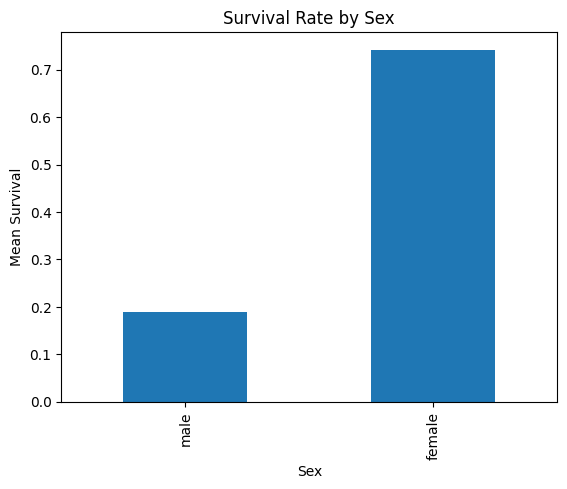

In [5]:
# Survival rate by Sex
survival_by_sex = train_df.groupby("Sex")["Survived"].mean().sort_values()
print("Survival rate by Sex:\n", survival_by_sex)

survival_by_sex.plot(kind="bar", title="Survival Rate by Sex")
plt.xlabel("Sex")
plt.ylabel("Mean Survival")
plt.show()

Survival rate by Pclass:
 Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


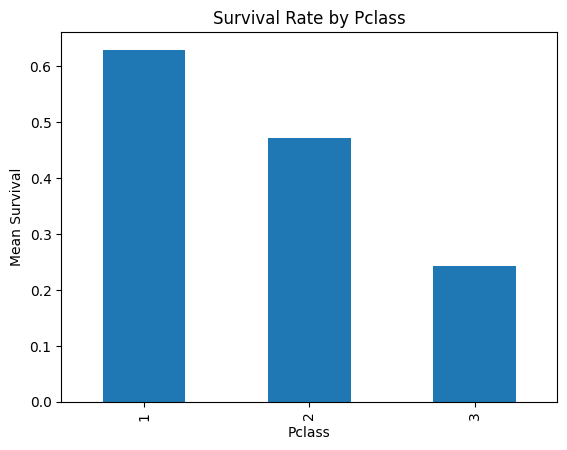

In [6]:
# Survival rate by Pclass
survival_by_pclass = train_df.groupby("Pclass")["Survived"].mean().sort_index()
print("Survival rate by Pclass:\n", survival_by_pclass)

survival_by_pclass.plot(kind="bar", title="Survival Rate by Pclass")
plt.xlabel("Pclass")
plt.ylabel("Mean Survival")
plt.show()

Conditional Survival (Pclass x Sex):
 Sex     female   male
Pclass               
1        0.968  0.369
2        0.921  0.157
3        0.500  0.135


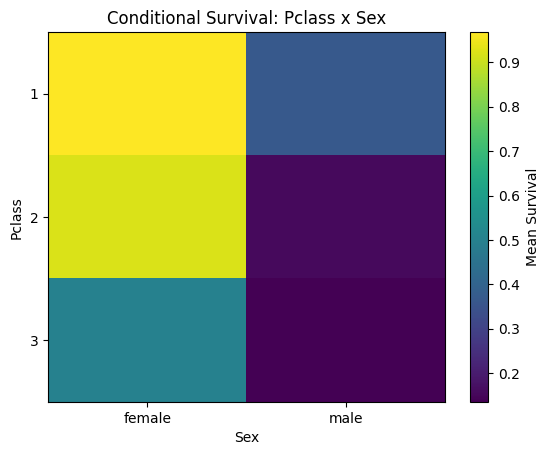

In [7]:
# Joint view: Pclass x Sex (pivot)
pivot = train_df.pivot_table(index="Pclass", columns="Sex", values="Survived", aggfunc="mean")
print("Conditional Survival (Pclass x Sex):\n", pivot.round(3))

plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.colorbar(label="Mean Survival")
plt.title("Conditional Survival: Pclass x Sex")
plt.xlabel("Sex")
plt.ylabel("Pclass")
plt.show()

Feature selection & preprocessing

We will use a compact, effective feature set:
	•	Numeric: Age, SibSp, Parch, Fare
	•	Categorical: Pclass, Sex, Embarked

Handling:
	•	Impute numeric with median; standardize.
	•	Impute categorical with mode; one-hot encode.
	•	Keep a fixed random_state and stratify by Survived.

In [8]:
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
target   = "Survived"

X = train_df[features].copy()
y = train_df[target].copy()

num_features = ["Age", "SibSp", "Parch", "Fare"]
cat_features = ["Pclass", "Sex", "Embarked"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

Train/validation split and baseline model

	•	Baseline model: LogisticRegression (max_iter=1000).
	•	Evaluate with Accuracy, ROC-AUC, confusion matrix, and a classification report.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, random_state=SEED))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
y_prob = clf.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)
cm  = confusion_matrix(y_val, y_pred)

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC:  {auc:.4f}")
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_val, y_pred))

Validation Accuracy: 0.8045
Validation ROC-AUC:  0.8427
Confusion matrix:
 [[98 12]
 [23 46]]

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



Predict on the test set and create submission

	•	Ensure the test set receives identical preprocessing.
	•	Note: test has occasional missing values (e.g., Fare) that the pipeline will impute.
	•	we expects a CSV with two columns: PassengerId, Survived.

In [16]:
# Make sure the test has the same feature columns
X_test = test_df[features].copy()

# Predict labels
test_pred = clf.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_pred
})
submission.to_csv("/content/drive/MyDrive/DSAI_5102/2_class_20250912Fri/data/result/submission.csv", index=False)

print("Saved submission.csv")
display(submission.head())

Saved submission.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


Stretch ideas (optional)

	•	Feature engineering:
	  •	FamilySize = SibSp + Parch + 1
	  •	IsAlone = (FamilySize == 1).astype(int)
	  •	Extract Title from Name (e.g., Mr/Mrs/Miss/Master)
	  •	Binary indicator: HasCabin = ~Cabin.isna()

	•	Model comparisons:
	  •	Try KNeighborsClassifier, DecisionTreeClassifier, or RandomForestClassifier.

	•	Calibration & curves:
	  •	Plot ROC curve and Precision-Recall curve using sklearn.metrics.
    
	•	Reproducibility:
	  •	Keep SEED fixed, log versions (np.__version__, pd.__version__, sklearn.__version__).
	  •	Save your validation predictions to CSV for grading.

Submitting to Kaggle

Once you have generated your submission.csv file, you can upload it to Kaggle to see your score.

https://www.kaggle.com/competitions/titanic/submissions#

	1.	Go to the Titanic Competition Submission Page.
	2.	Make sure you are logged in to your Kaggle account.
	3.	Click on Upload Submission.
	4.	Select your submission.csv file and submit it.
	5.	Kaggle will automatically evaluate your predictions against the hidden test labels and give you an Accuracy score on the leaderboard.